In [27]:
import utils.dataset_utils as dataset
import utils.train_utils as train

import numpy as np
import copy
import pickle

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 250

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [3]:
NORMALIZE = False
file_location = "../data/Raman_Mouse/approximated/"
file_location_org = "../data/Raman_Mouse/corrected_4_wavenumbers/"
filenames = np.load(f"{file_location_org}FileNames.npy")
with open(f'{file_location_org}Sample_labels.pickle', 'rb') as f:
    labels = pickle.load(f)

vector_norm = unit_vector_norm if NORMALIZE else lambda x: x
    
data = []
split_data = []
for f in filenames:
    raw = np.load(f"{file_location_org}{f.split('.')[0]}.npy")
    data.append(vector_norm(raw.reshape(-1,raw.shape[-1])).reshape(raw.shape))
    
    photo = np.load(f"{file_location}{f.split('.')[0]}_photoluminescence.npy")
    raman = np.load(f"{file_location}{f.split('.')[0]}_raman.npy")
    split_data.append((raman,photo,labels[f]))

In [4]:
rng = np.random.default_rng()

class Kalman():    
    def __init__(self, X, grad, e, neighbourhood, photo_smoothness = 5000, noise_smoothness = 2, correct_photo_appr_blacknoise=True):
        self.X = X
        self.N_wavenumbers = self.X.shape[0]
        self.N_photo_appr = X.shape[1] - 1
        self.photo_smoothness = photo_smoothness
        self.noise_smoothness = noise_smoothness
        
        self.C = np.array([[1,1]] +
                           [[1,0]] * self.N_photo_appr)
        self.A = np.zeros((self.N_wavenumbers, 2, 2))
        self.A[:,0,0] = grad
        self.A[:,1,1] = 1
        
        if correct_photo_appr_blacknoise:
            self.e = np.array([e] * X.shape[1])
        else:
            self.e = np.array([e] + [0] * self.N_photo_appr)
            
        self.n = neighbourhood
        self.mu = np.empty((self.N_wavenumbers, 2))
        self.M = np.empty((self.N_wavenumbers, 2, 2))
        self.nu = np.empty((self.N_wavenumbers+1, 2))
        self.V = np.empty((self.N_wavenumbers+1, 2, 2))
        self.J = np.empty((self.N_wavenumbers, 2, 2))

        self.nu[0] = [X[0,0], 0]
        
        self.Sigma = np.diag(rng.standard_normal(1 + self.N_photo_appr))
        self.Gamma = np.diag(rng.standard_normal(2))
        self.V[0] = [[0, 0],
                     [0, 0]]
    
    @property
    def raw_data(self):
        return self.X, self.A[:,0,0]
    
    @raw_data.setter
    def raw_data(self, args):
        value, grad = args
        self.X = value
        self.nu[0] = [self.X[0,0], 0]
        self.A[:,0,0] = grad
        self.EM(1)
        
    def _filter_step(self, i):
        CV = self.C @ self.V[i]
        b = self.C @ self.nu[i] + self.e
        B = CV @ self.C.T + self.Sigma 
        K = self.V[i] @ self.C.T @ np.linalg.inv(B)
        self.mu[i] = self.nu[i] + K @ (self.X[i] - b)
        self.M[i] = self.V[i] - K @ CV

        # transition
        self.nu[i+1] = self.A[i] @ self.mu[i]
        self.V[i+1] = self.A[i] @ self.M[i] @ self.A[i] + self.Gamma # A = A.T
        
    def _smoother_step(self, i):
        self.J[i] = self.M[i-1] @ self.A[i] @ np.linalg.inv(self.V[i])
        self.M[i-1] += self.J[i] @ (self.M[i] - self.V[i]) @ self.J[i].T
        self.mu[i-1] += self.J[i] @ (self.mu[i] - self.nu[i])
    
    def kalman_filter(self):
        for i in range(len(self.X)):
            self._filter_step(i)
            
    def kalman_smoother(self):
        self.kalman_filter()
        
        for i in range(len(self.X)-1, 0, -1):
            self._smoother_step(i)
            
    def EM(self, n):
        lst = [copy.copy(self.A[:,0,0])]
        lst2 = []
        for i in range(n):
            self.kalman_smoother()
            E_z = self.mu
            E_zz = self.M + self.mu.reshape(-1,self.mu.shape[1],1) @ self.mu.reshape(-1,1,self.mu.shape[1])
            E_z_1z = (self.J @ self.M)[1:] + self.mu[:-1].reshape(-1,self.mu.shape[1],1) @ self.mu[1:].reshape(-1,1,self.mu.shape[1])

            # skip nu_0, V_0, A and C
            self.Gamma = np.sum(E_zz[1:] - 
                                E_z_1z.transpose(0,2,1) @ self.A[:-1].transpose(0,2,1) - 
                                self.A[:-1] @ E_z_1z + 
                                self.A[:-1] @ E_zz[:-1] @ self.A[:-1].transpose(0,2,1),
                                0) / self.N_wavenumbers
    
            self.Sigma = (self.X.T @ self.X - 
                         self.C @ E_z.T @ self.X - 
                         self.X.T @ E_z @ self.C.T + 
                         np.sum(self.C @ E_zz @ self.C.T, 0)) / (self.N_wavenumbers + 1)
            
            # make covarience diagonal
            self.Sigma = np.diag(np.diag(self.Sigma)) 
            self.Sigma[0,0] /= self.noise_smoothness
            self.Sigma[0,0] += 1e-3
            
            c = (self.Gamma[0,0] + self.Gamma[1,1]) / self.photo_smoothness
            self.Gamma = np.diag([c, c*(self.photo_smoothness-1)])
            
            
def split_signal(img, photo_smoothness=10, noise_smoothness = 2):
    black_noise = 0
    
    x = img.reshape(-1, img[0].shape[-1])
    grad = np.ones(x.shape[1])

    obj = Kalman(np.stack((x[0], x[0])).T, grad, black_noise, 1, photo_smoothness=photo_smoothness, noise_smoothness=noise_smoothness)
    obj.EM(10)
    
    raman = np.empty(x.shape)
    photo = np.empty(x.shape)
    
    for pixel in range(x.shape[0]):   
        obj.raw_data = np.stack((x[pixel], x[pixel])).T, grad
        
        raman[pixel] = obj.mu[:,1]
        photo[pixel] = obj.mu[:,0]
        
    return raman, photo, x

In [5]:
import timeit
from os import path
from scipy import stats

file_location2 = "../data/Raman_Mouse/black_noise_removed/"
shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue
    sm = 10
    blacknoise, raman, x = split_signal(img, photo_smoothness=sm, noise_smoothness = 20)
    
#     for pixel in range(x.shape[0]):  
#         plt.title(f"smoothing is {sm}")
#         plt.plot(x[pixel], label='raw')
#         plt.plot(raman[pixel], label='raman')
#         plt.plot(photo[pixel], label='photo')
#         plt.plot(photo[pixel]+raman[pixel], label='reconstruction', alpha=.3)
#         plt.plot([0,1300],[0,0], 'k', alpha=0.3)
#         plt.xlim(0,1300)
#         plt.ylim(-100,5000)
#         plt.legend()
#         plt.show()
#         break

    stop = timeit.default_timer()
    print('Time: ', stop - start)
    break
#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
#     print(f"image: {f} is done.")
    

Time:  325.71656599999994


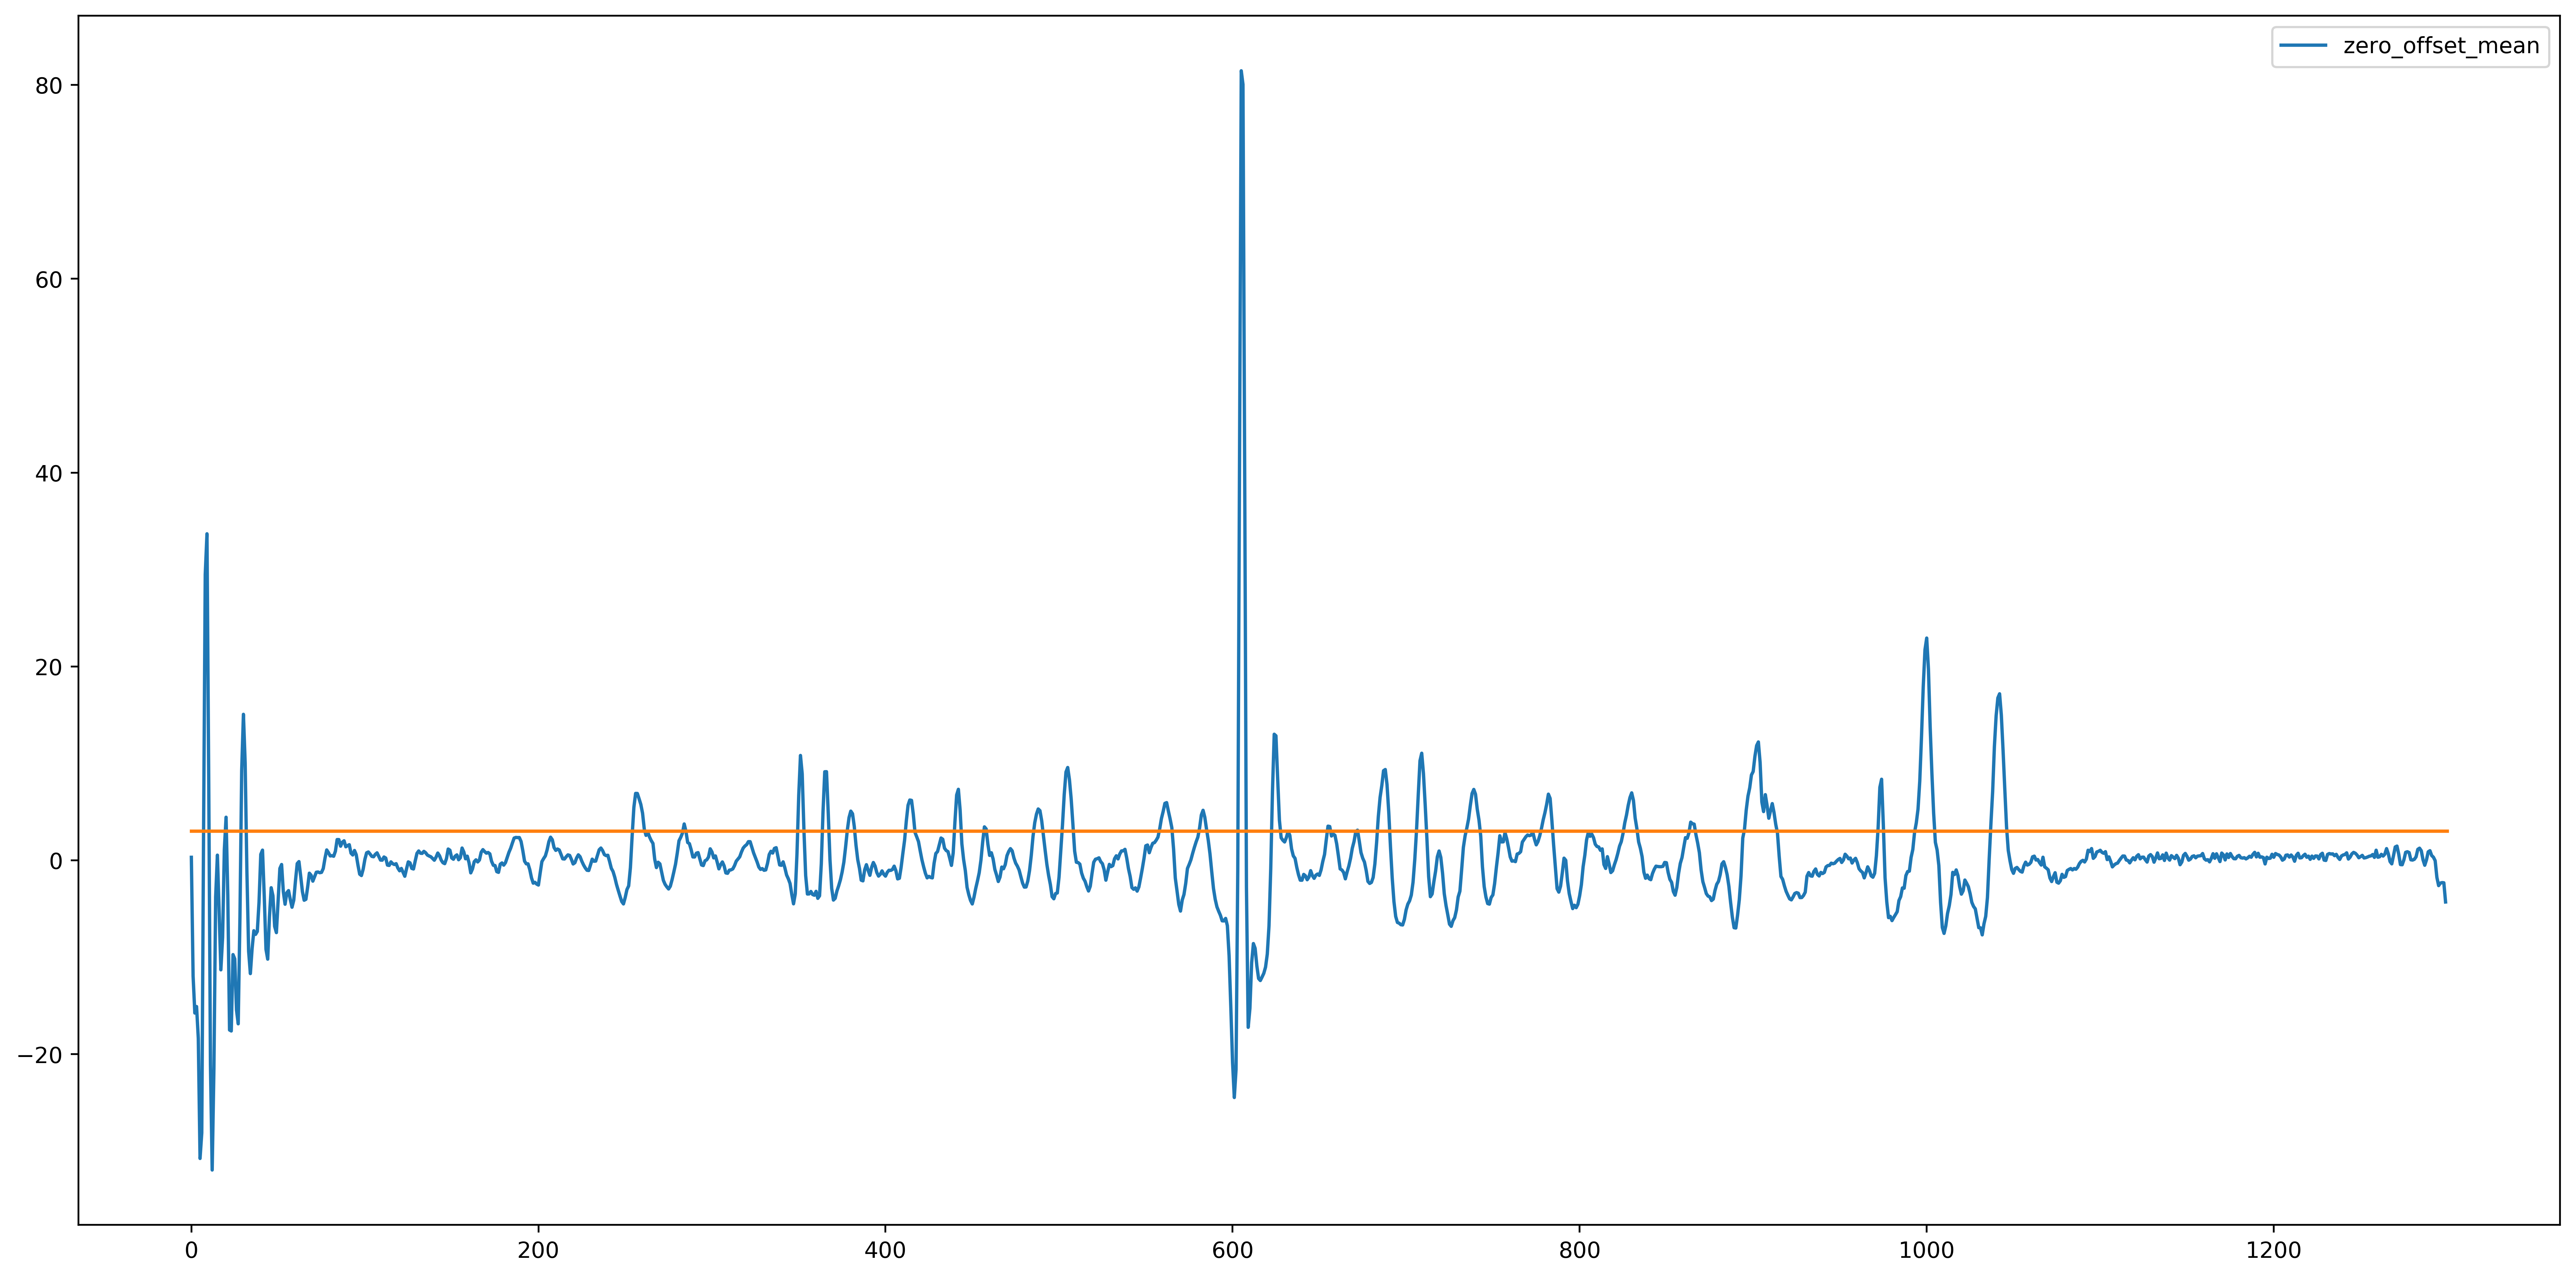

In [13]:
threshold = 3
pixel_mean = np.mean(blacknoise, 1)
zero_offset_blacknoise =  blacknoise - pixel_mean[:,None]
avg_spikes = np.mean(zero_offset_blacknoise, 0)

plt.plot(avg_spikes,label="zero_offset_mean")
plt.plot([0,1300],[threshold, threshold])
plt.legend()
plt.show()


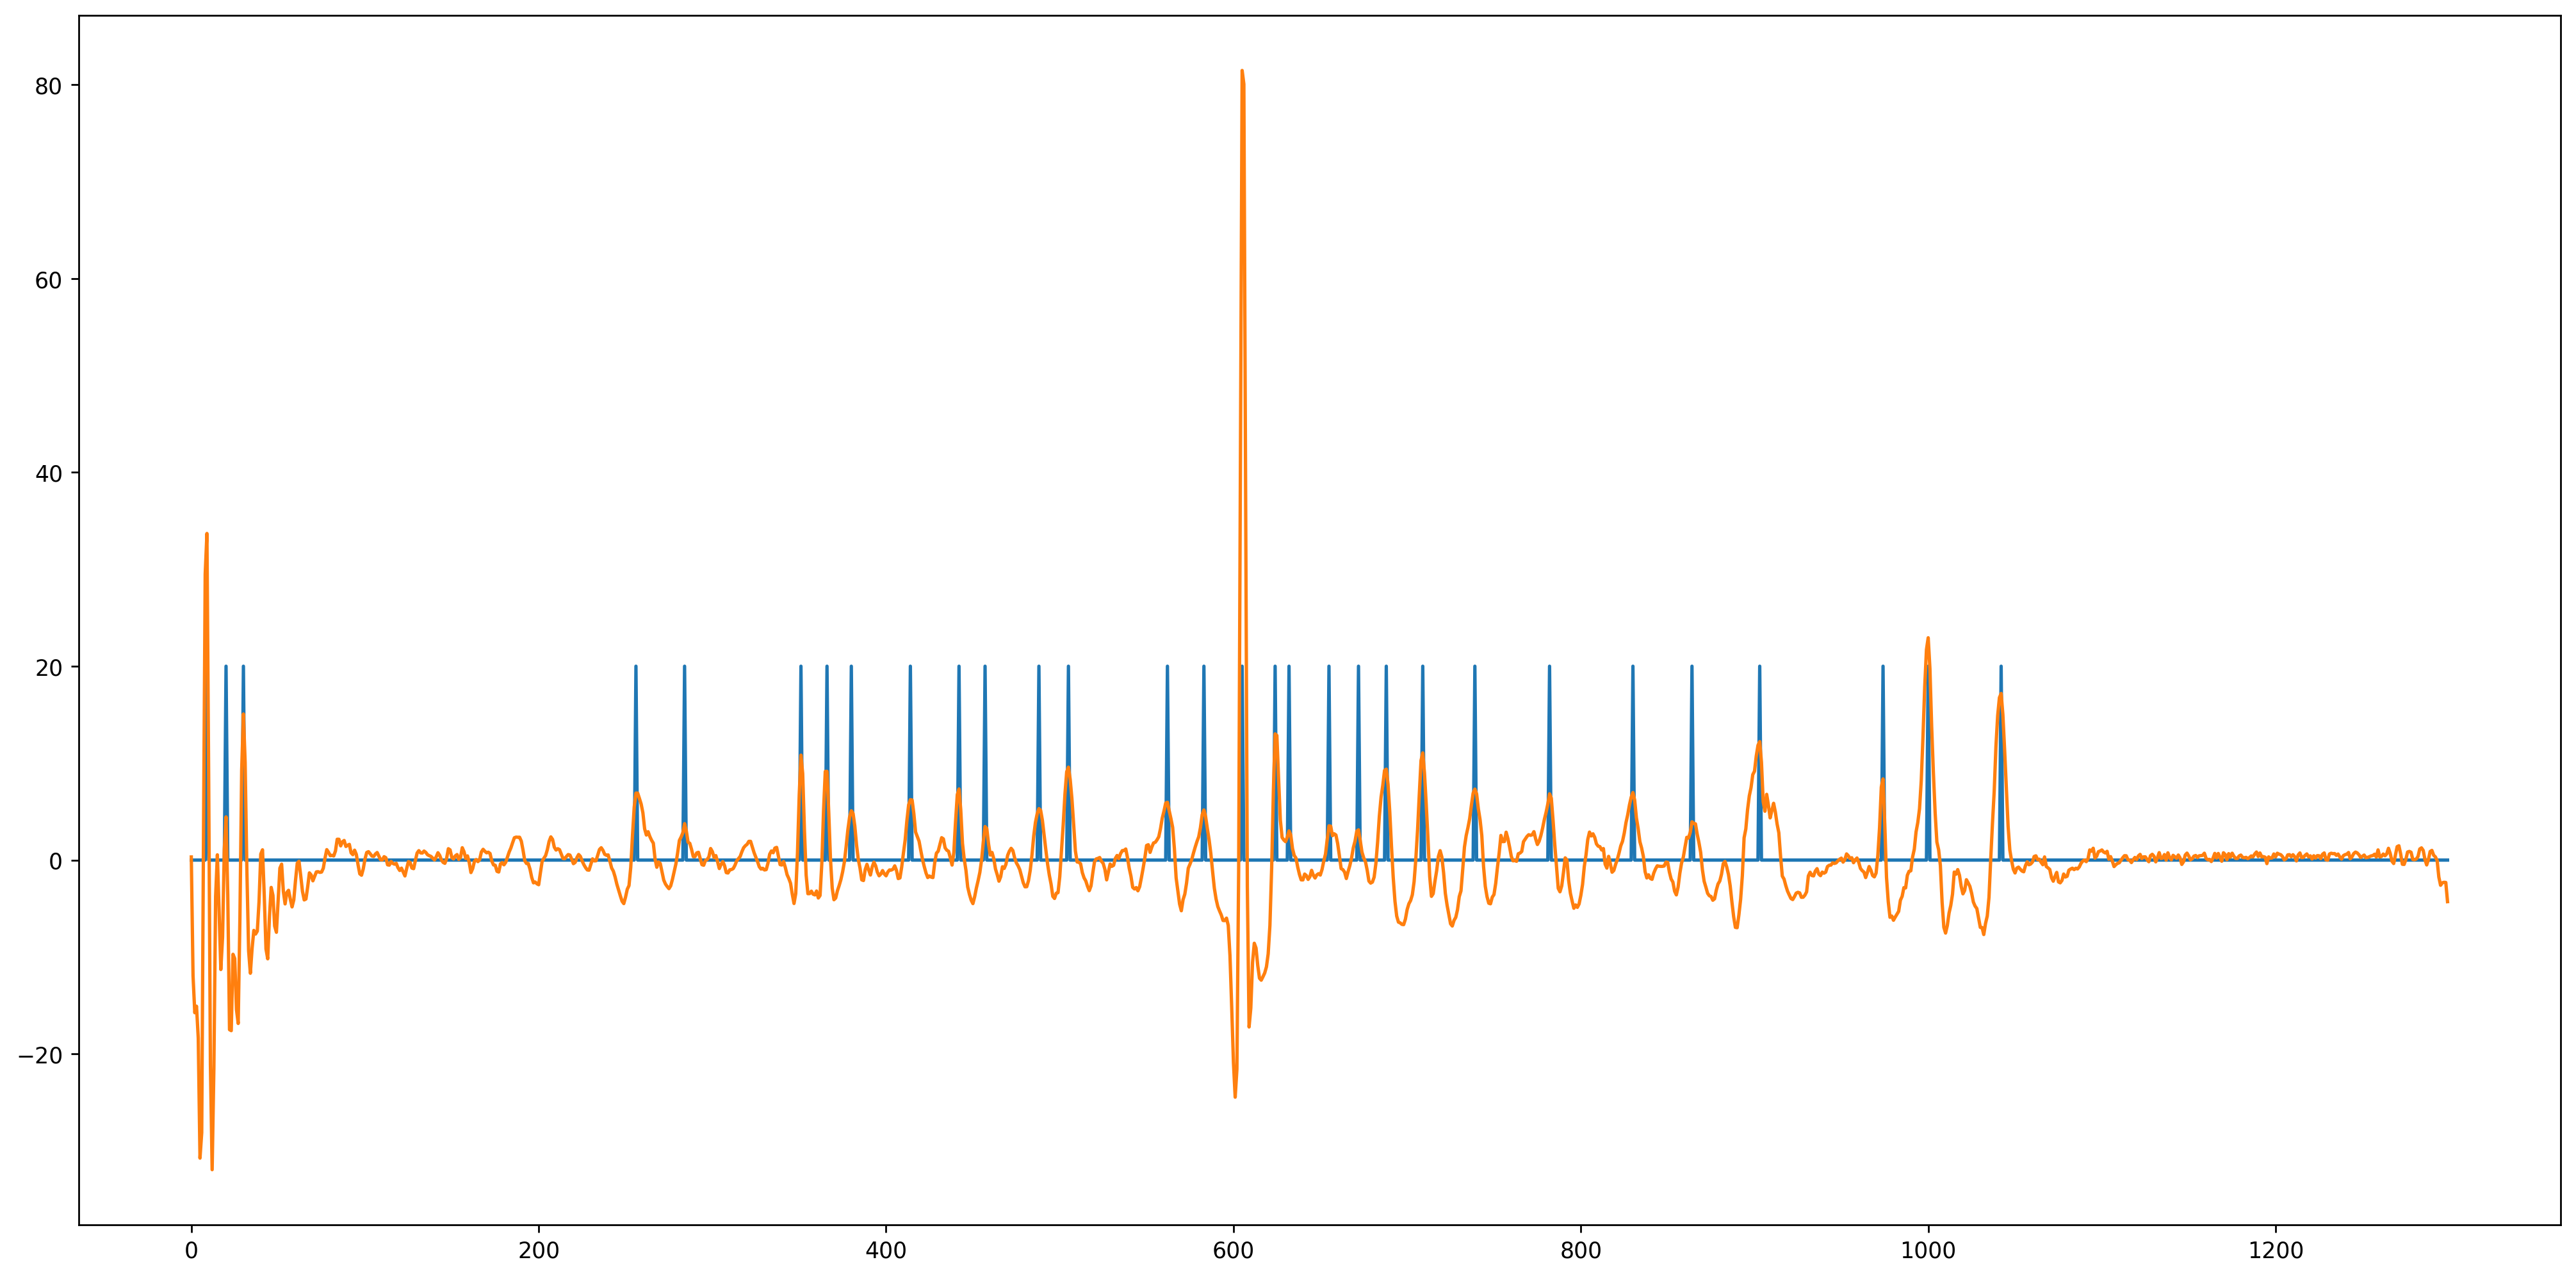

In [40]:
# find the spikes
mask = avg_spikes > threshold
for i, v in enumerate(mask):
    if not v:
        continue
    
    # find the end of the spike
    n = 1
    while mask[i+n]:
        n += 1
        
    # set the maximum value to one the rest to zero
    j = np.argmax(avg_spikes[i:i+n])
    mask[i:i+n] = 0
    mask[i+j] = 1

plt.plot(mask*20)
plt.plot(avg_spikes)

In [41]:
img = data[0]
from sklearn.cluster import KMeans

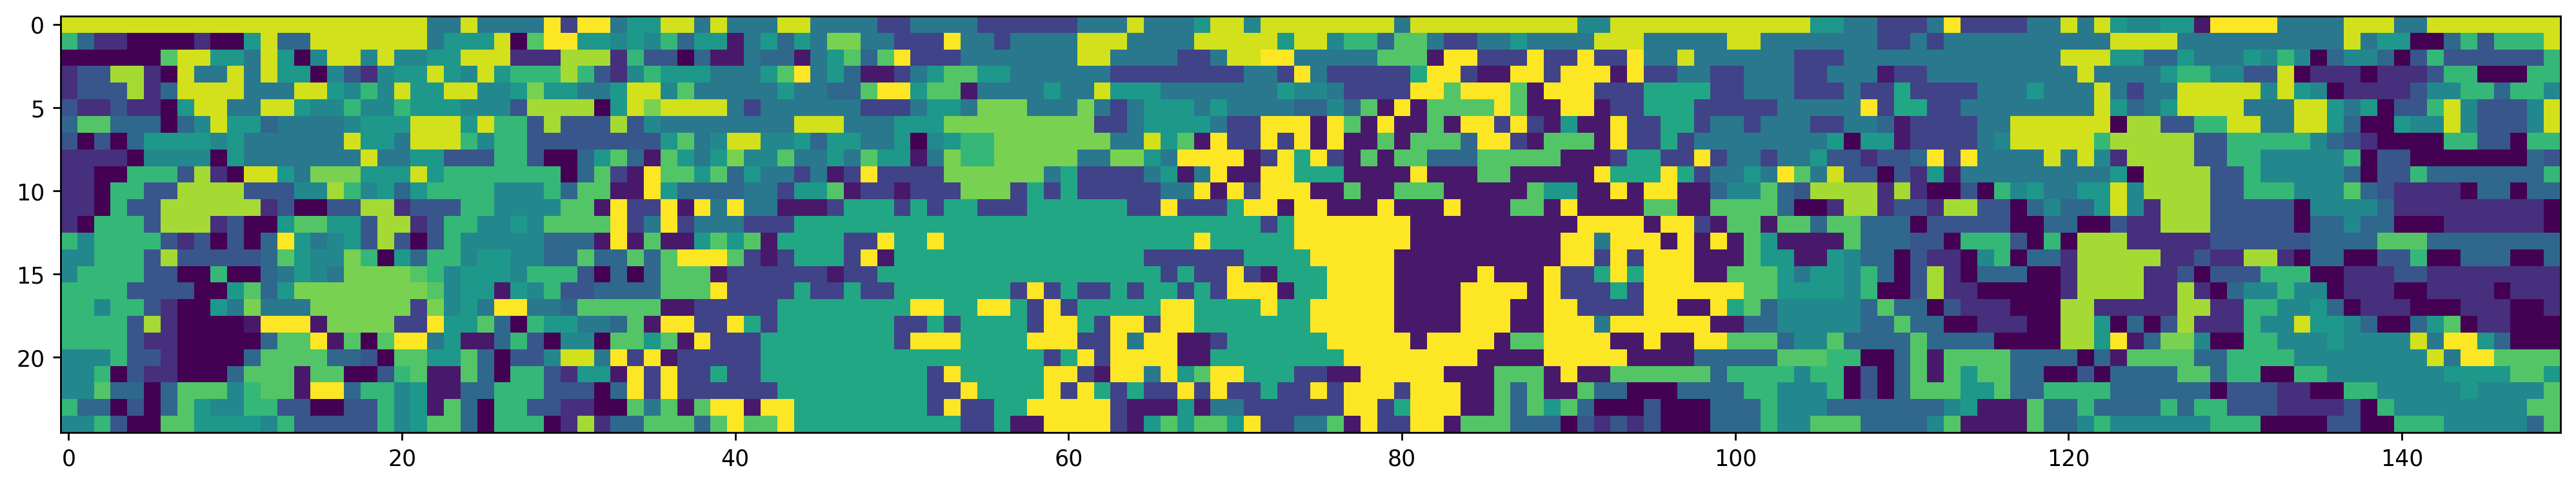

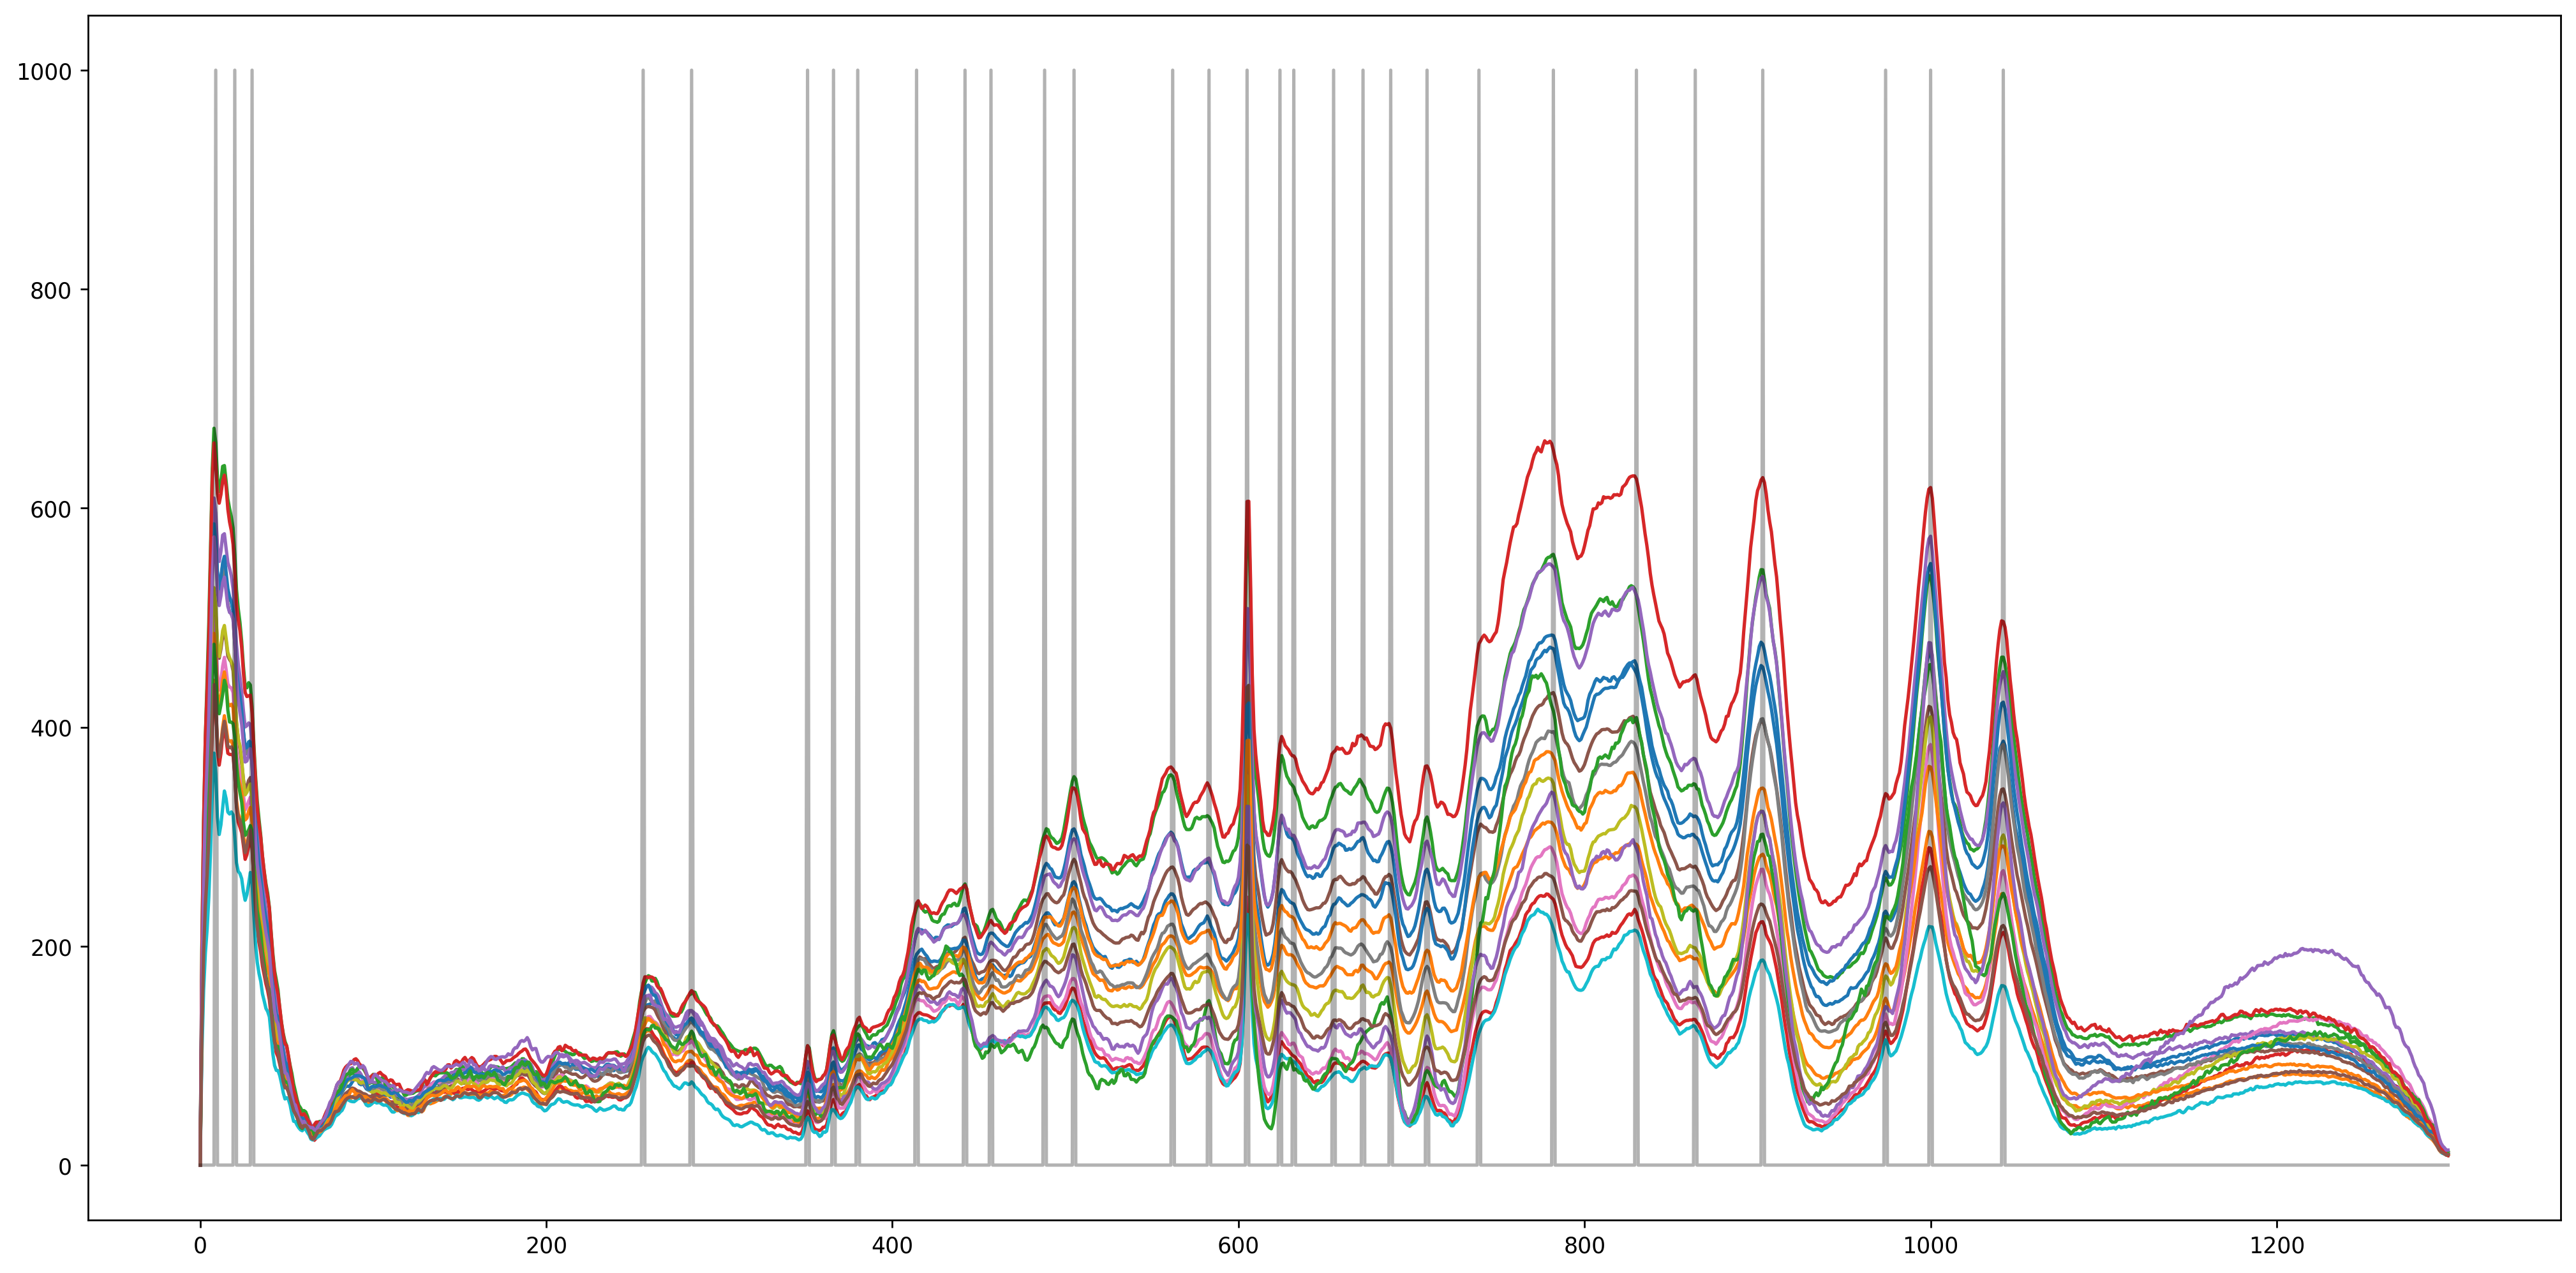

In [42]:
# clustering using the splke in the Raman data
clusters = 16
kmeans = KMeans(n_clusters=clusters).fit(split_data[0][0].reshape(-1,1300)[:,mask])
labels = kmeans.labels_.reshape(img.shape[0],-1)
plt.imshow(labels.T)
plt.show()

for i in range(clusters):
    plt.plot(np.mean(split_data[0][0][np.where(labels==i)], 0))
plt.plot(mask*1000, 'k', alpha=0.3)
plt.show()

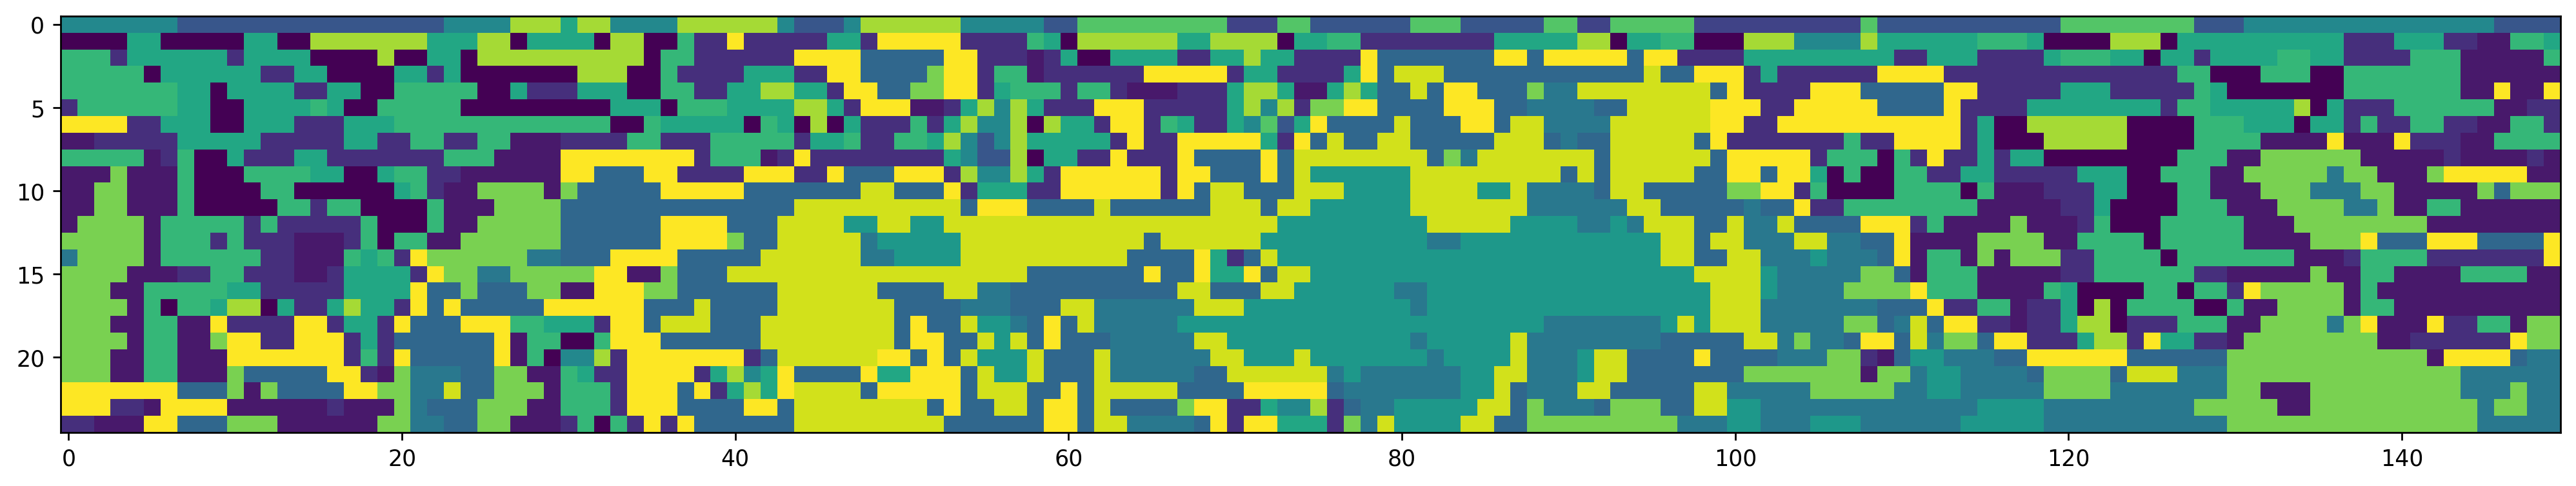

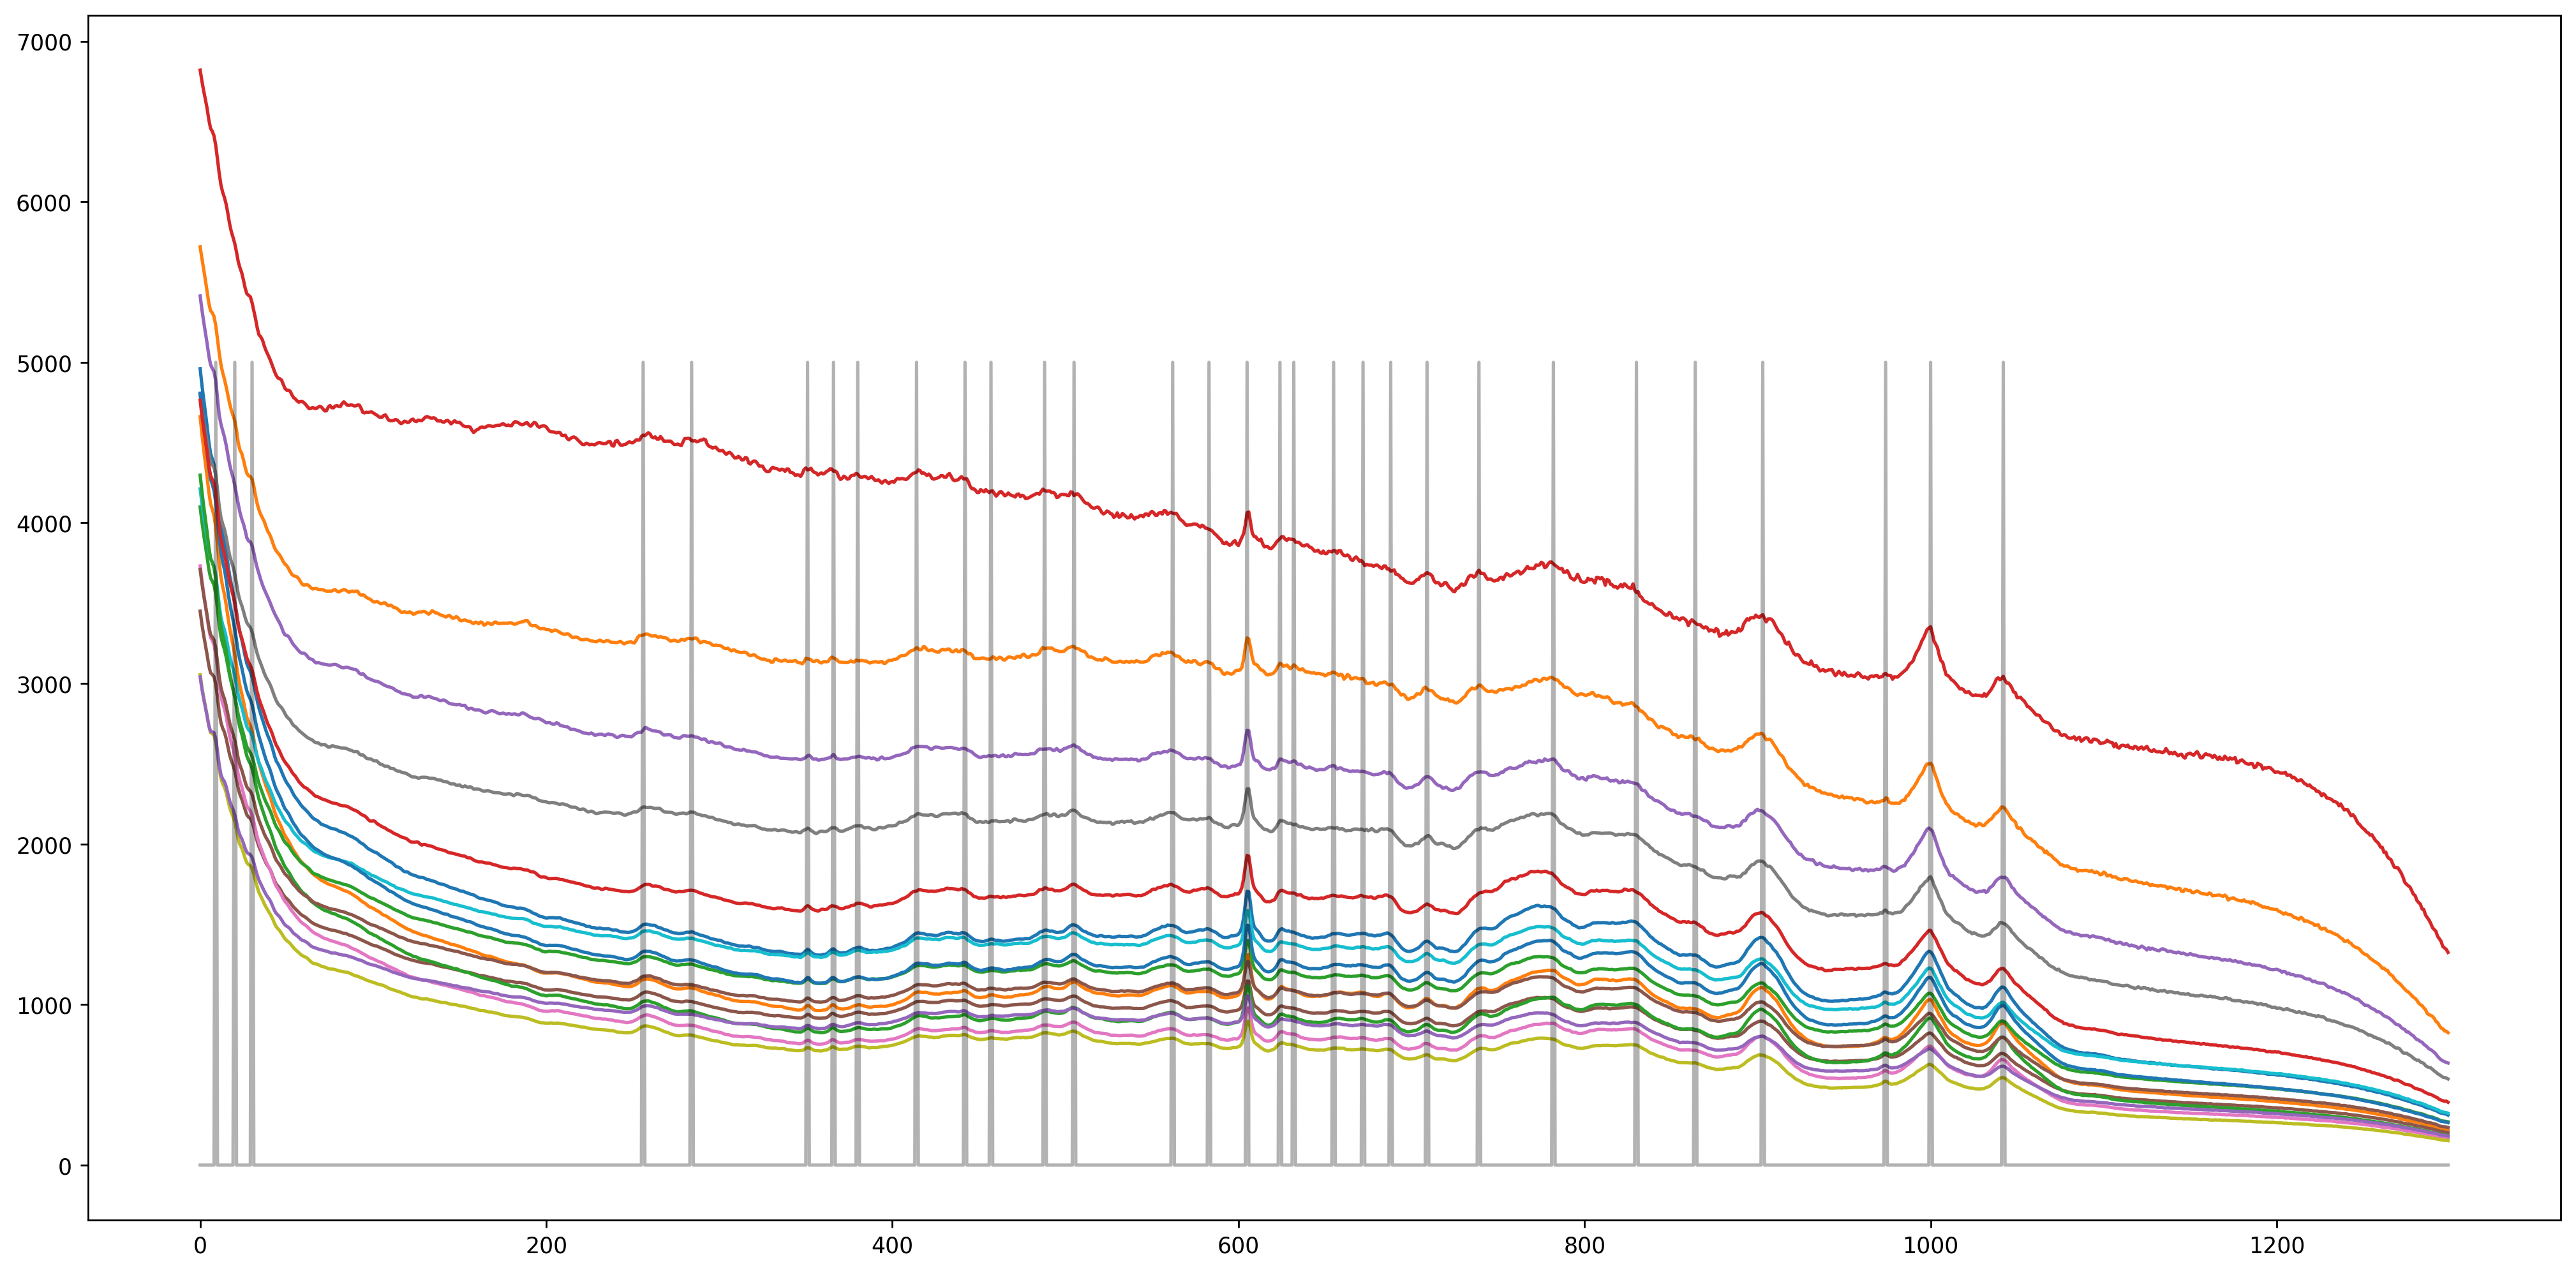

In [43]:
# clustering using the splke in the smoothed raw signal
kmeans = KMeans(n_clusters=clusters).fit(raman[:,mask])
labels = kmeans.labels_.reshape(img.shape[0],-1)
plt.imshow(labels.T)
plt.show()

for i in range(clusters):
    plt.plot(np.mean(img[np.where(labels==i)], 0))
plt.plot(mask*5000, 'k', alpha=0.3)
plt.show()

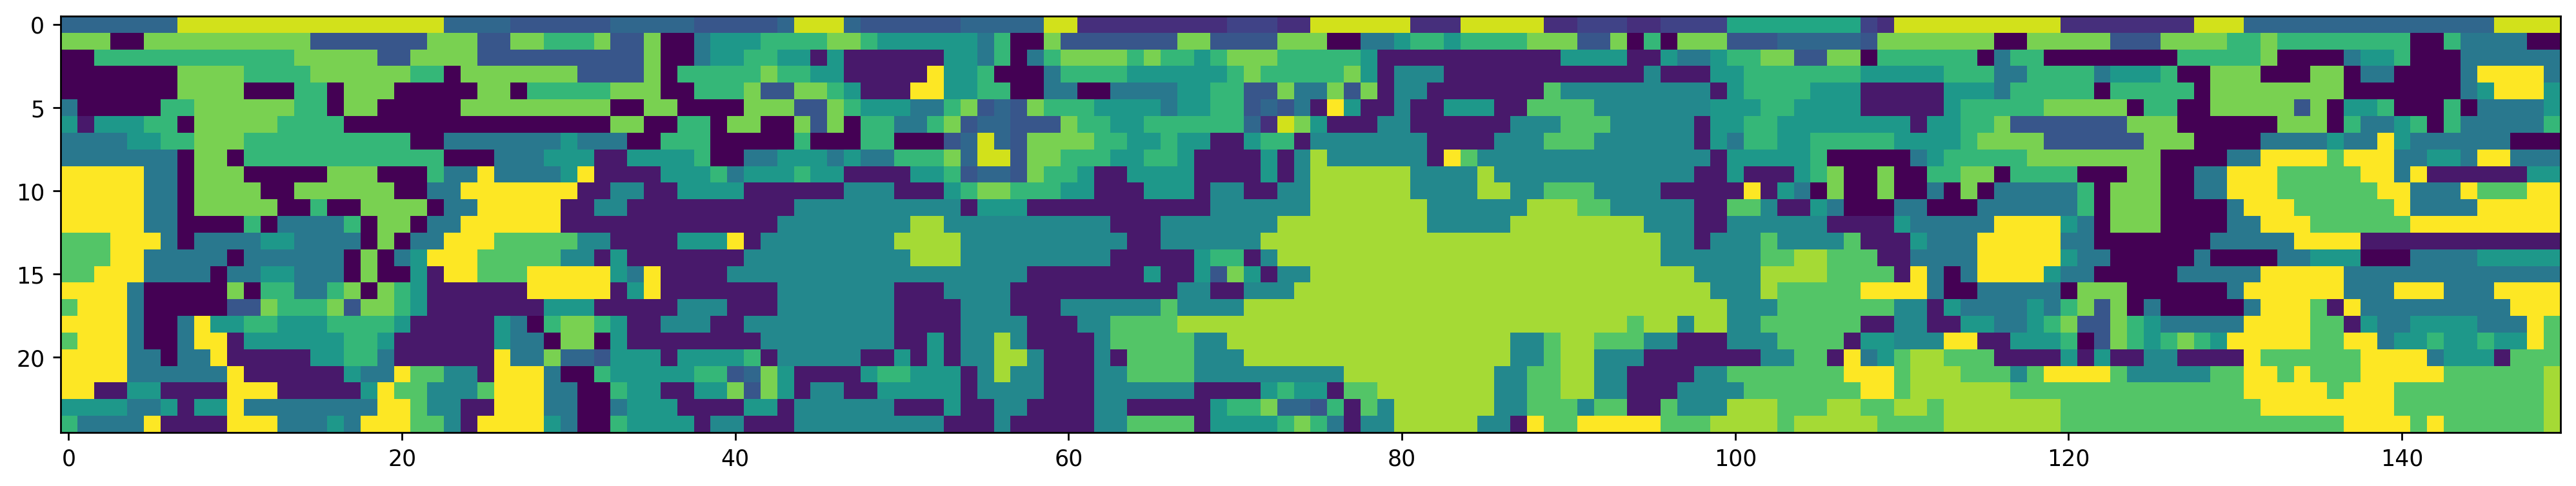

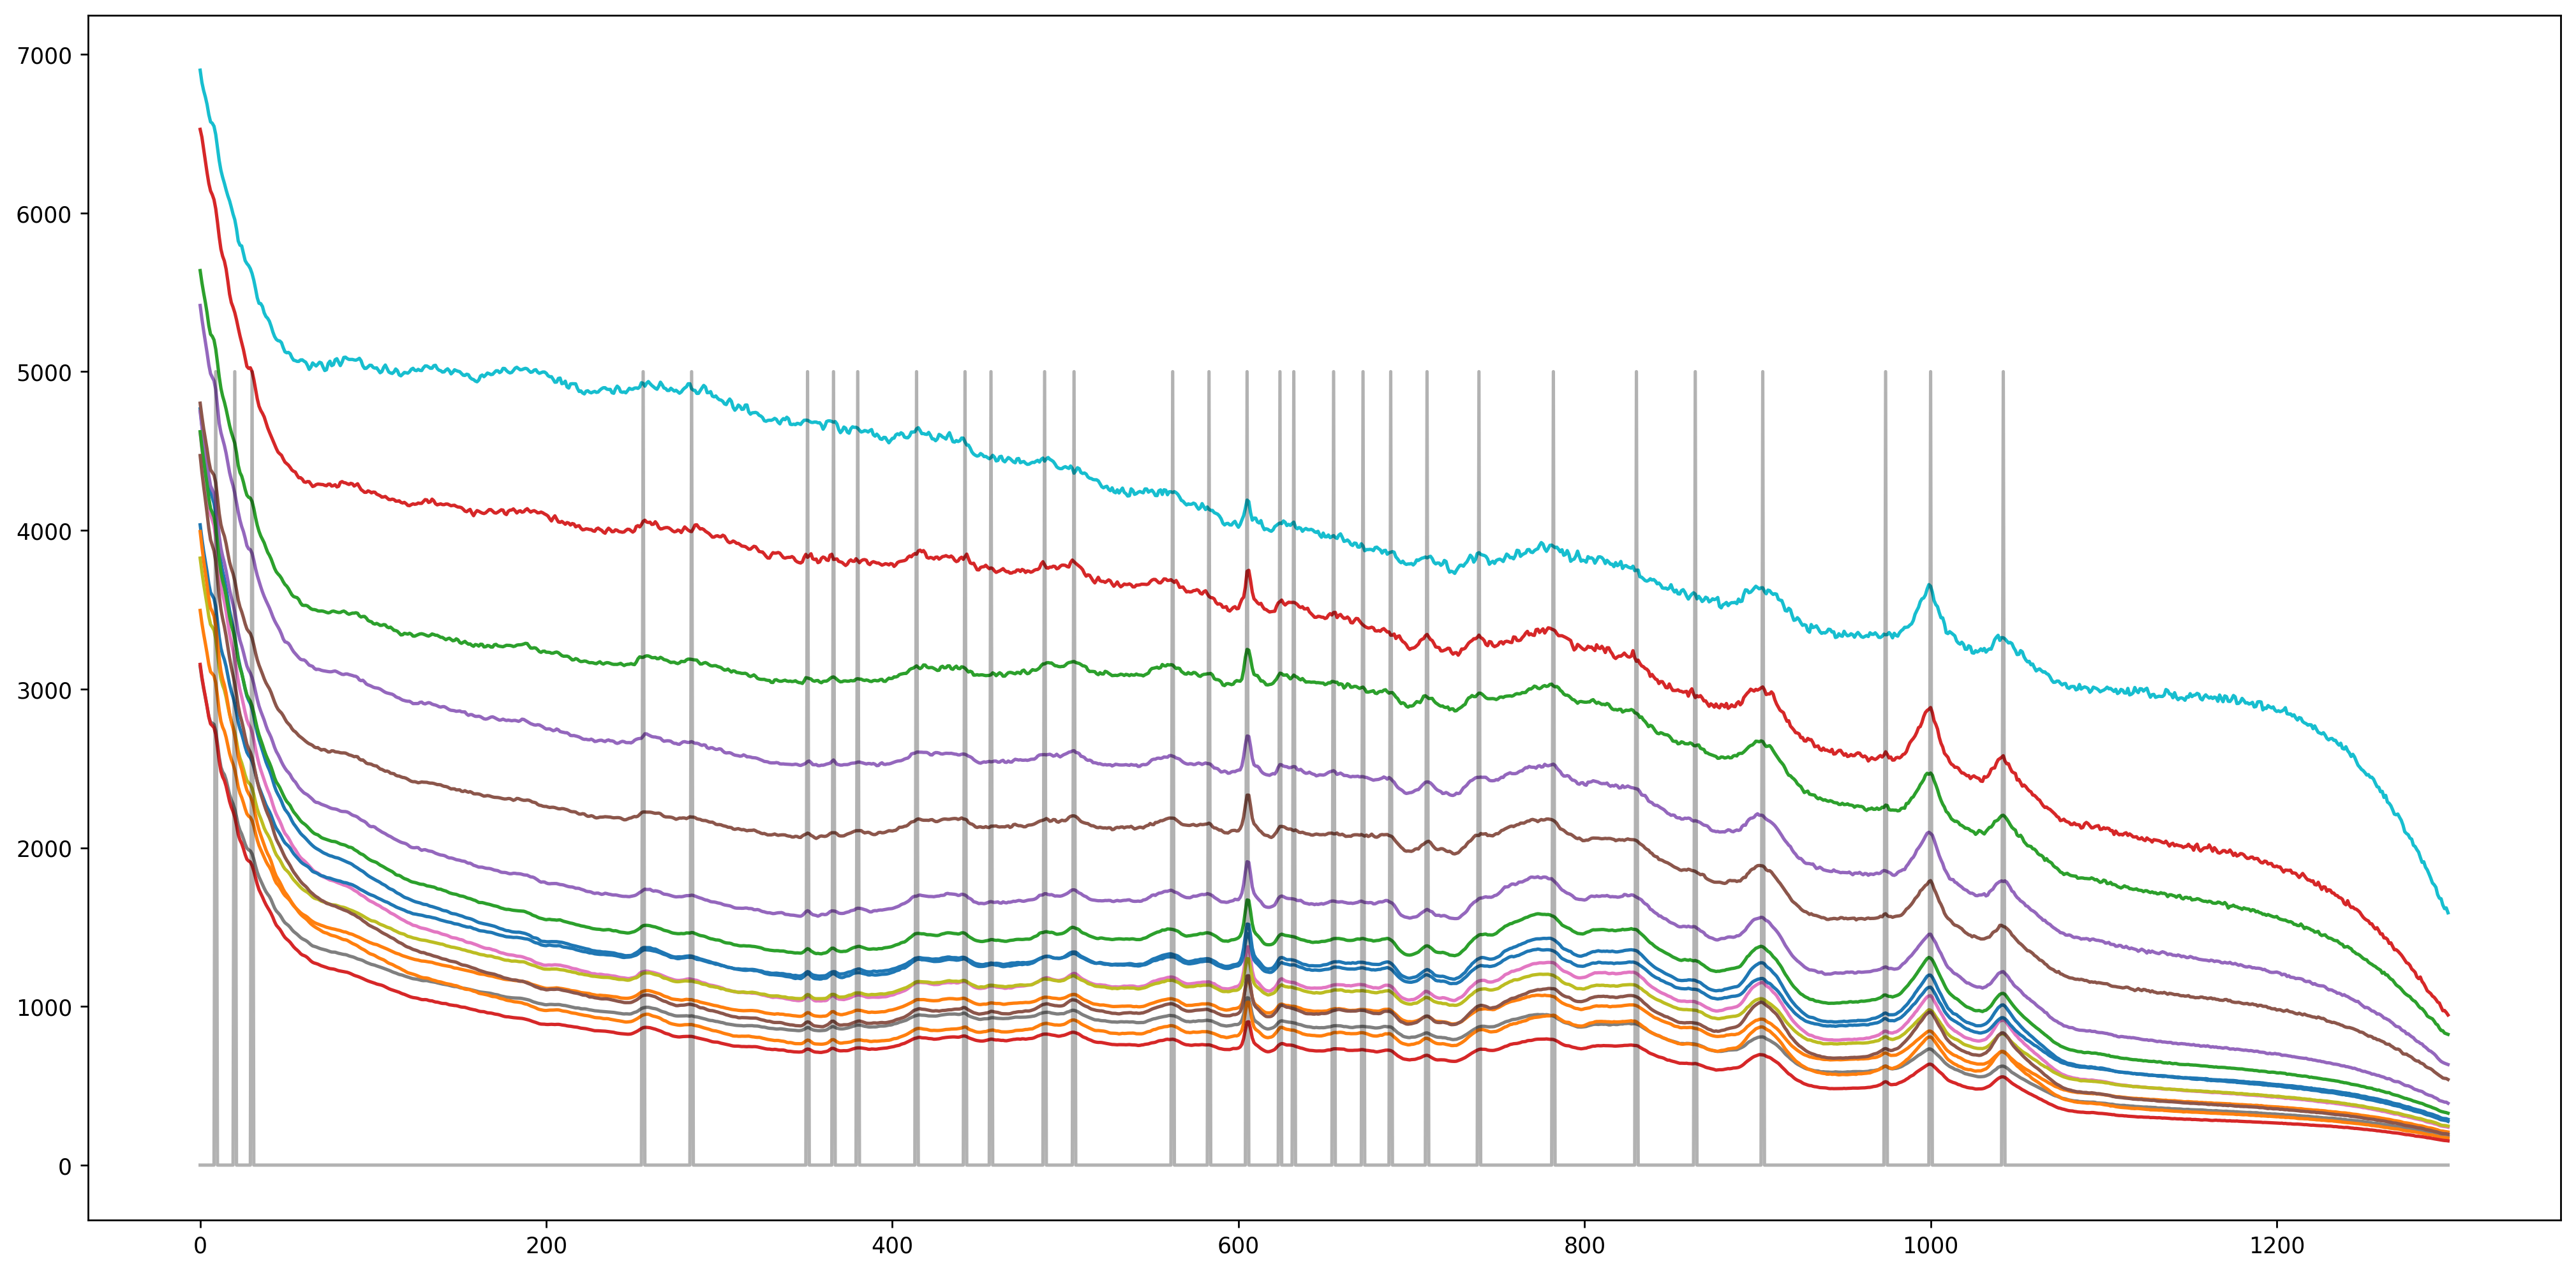

In [44]:
# clustering using the smoothed raw signal
kmeans = KMeans(n_clusters=clusters).fit(raman)
labels = kmeans.labels_.reshape(img.shape[0],-1)
plt.imshow(labels.T)
plt.show()

for i in range(clusters):
    plt.plot(np.mean(img[np.where(labels==i)], 0))
plt.plot(mask*5000, 'k', alpha=0.3)
plt.show()

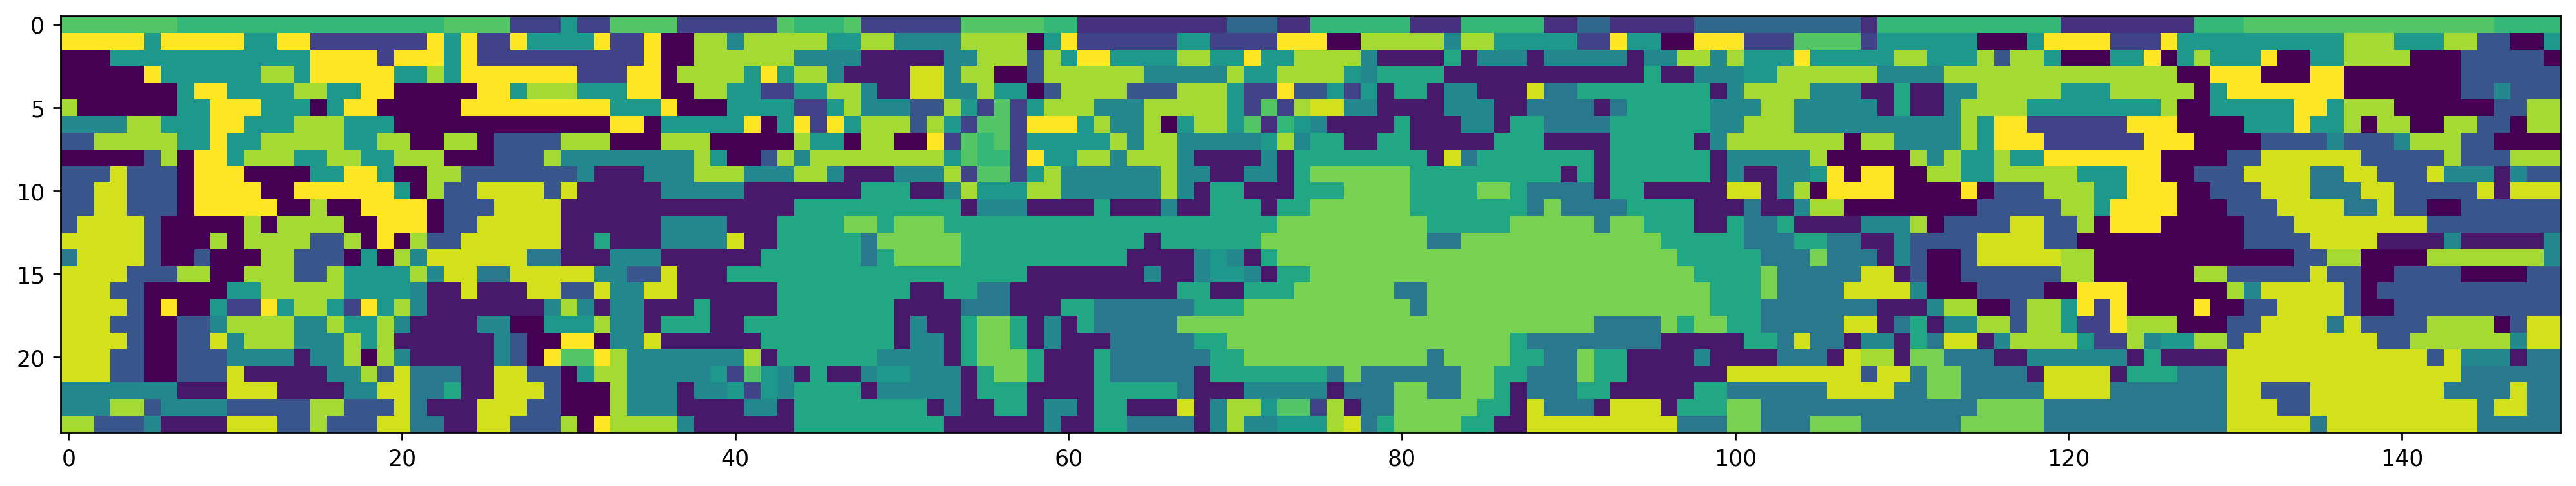

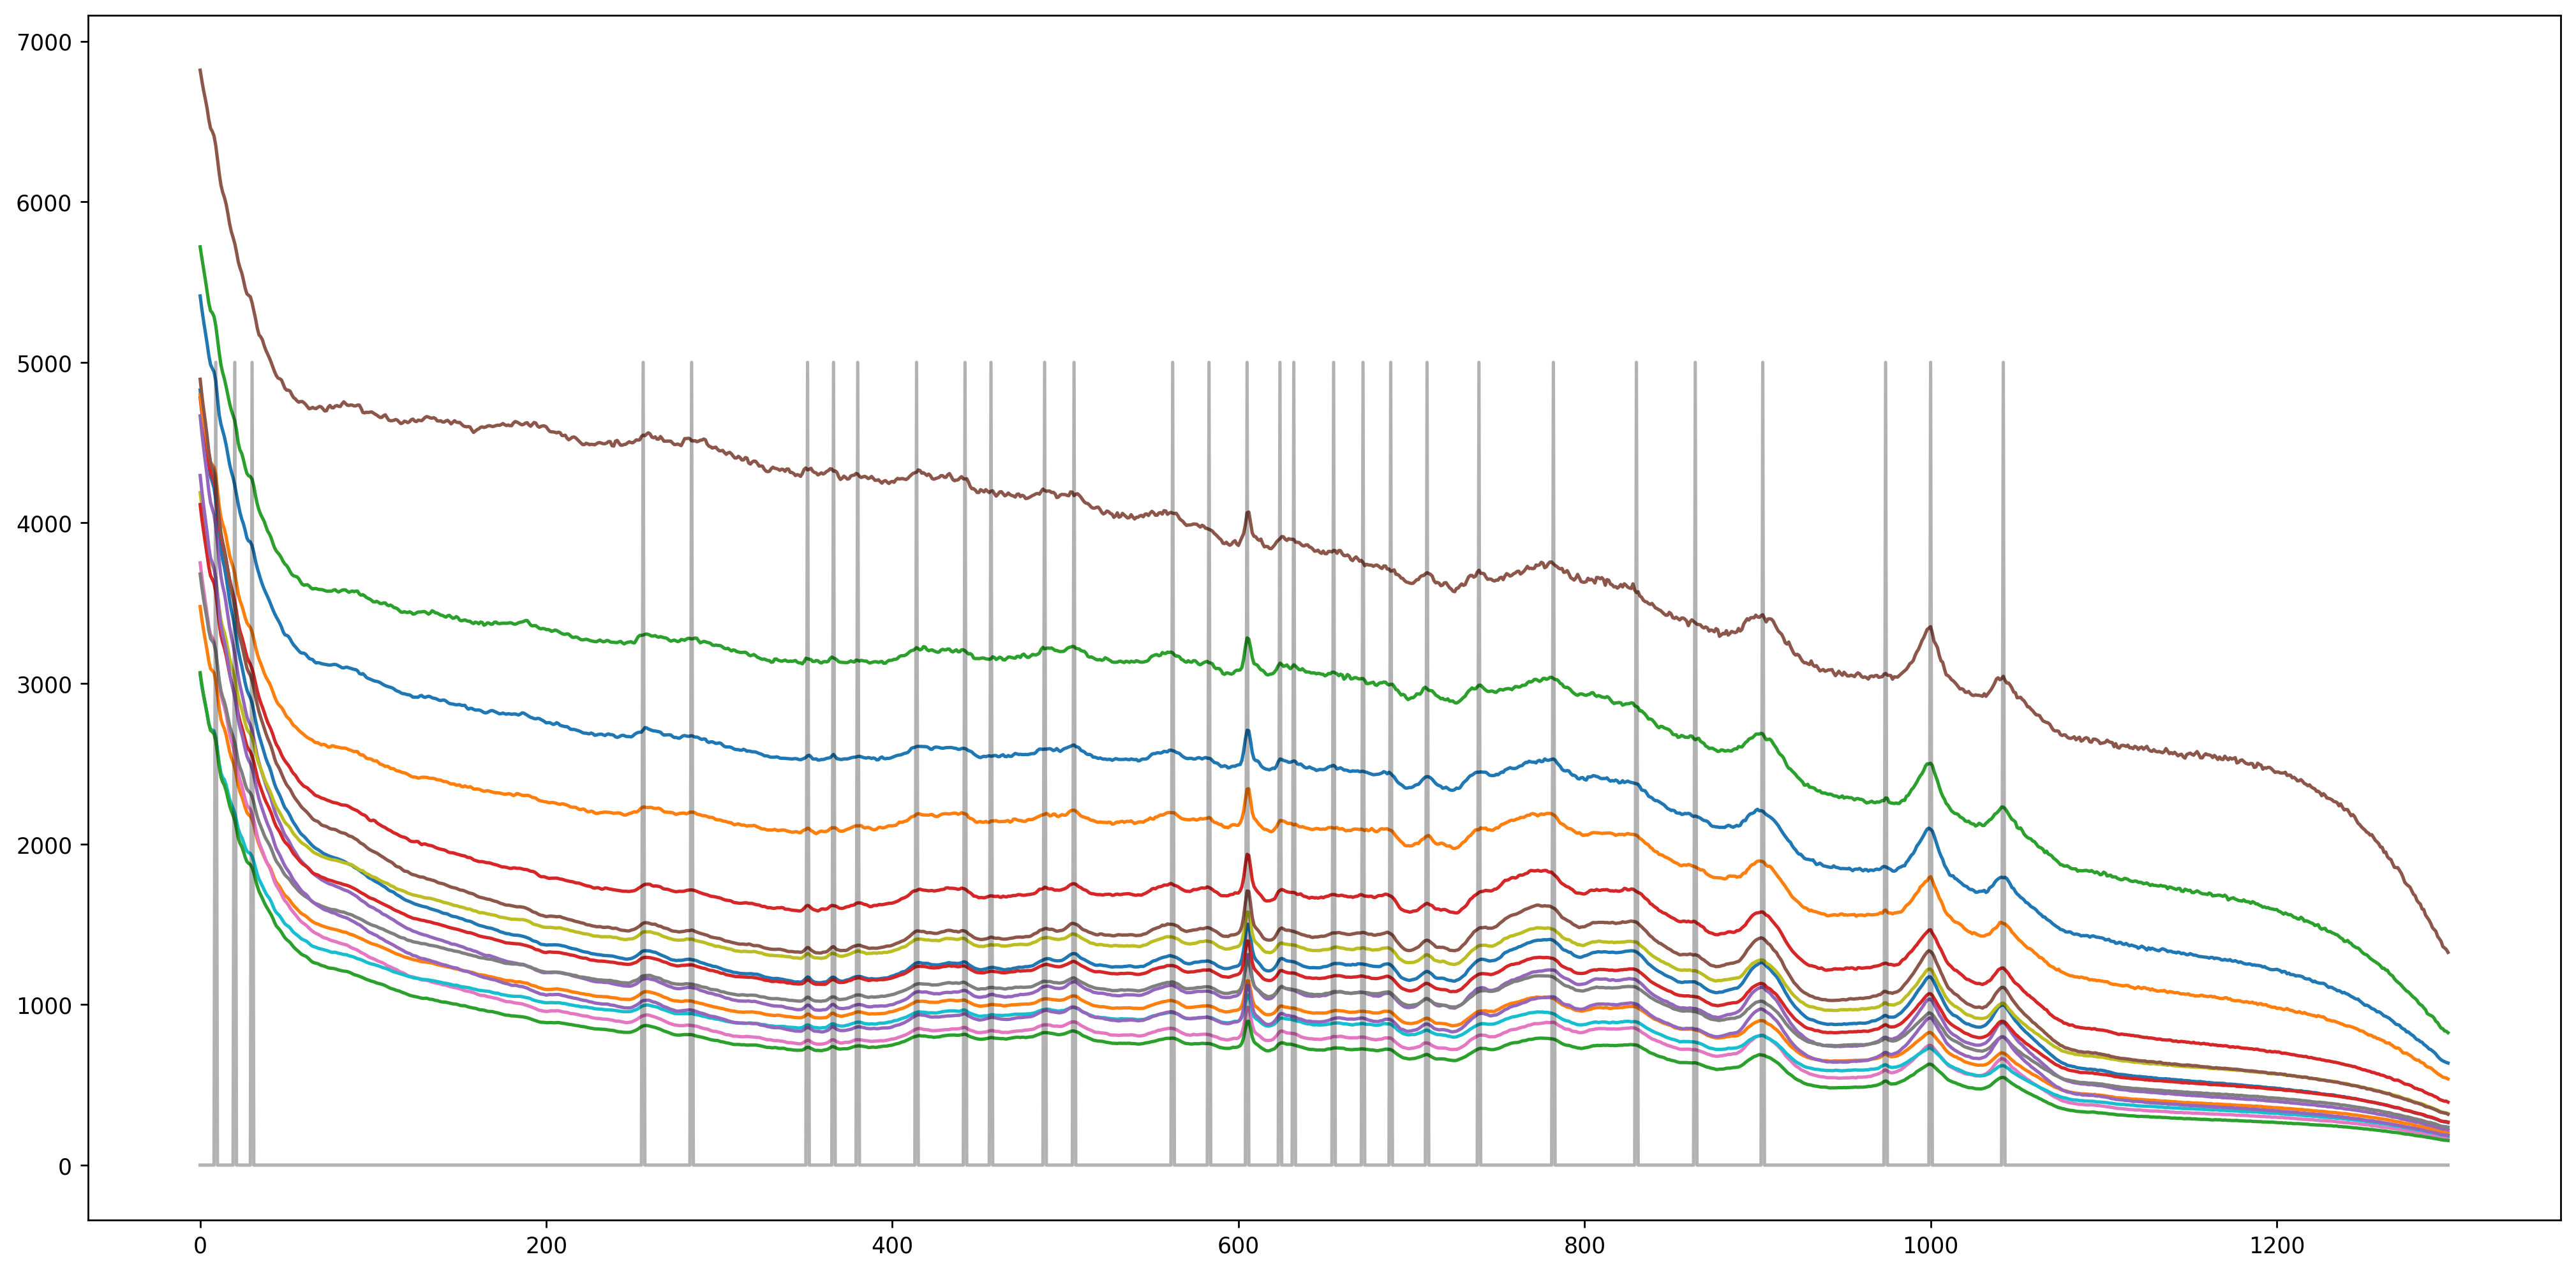

In [45]:
# clustering using the spikes in the raw signal
kmeans = KMeans(n_clusters=clusters).fit(x[:,mask])
labels = kmeans.labels_.reshape(img.shape[0],-1)
plt.imshow(labels.T)
plt.show()

for i in range(clusters):
    plt.plot(np.mean(img[np.where(labels==i)], 0))
plt.plot(mask*5000, 'k', alpha=0.3)
plt.show()

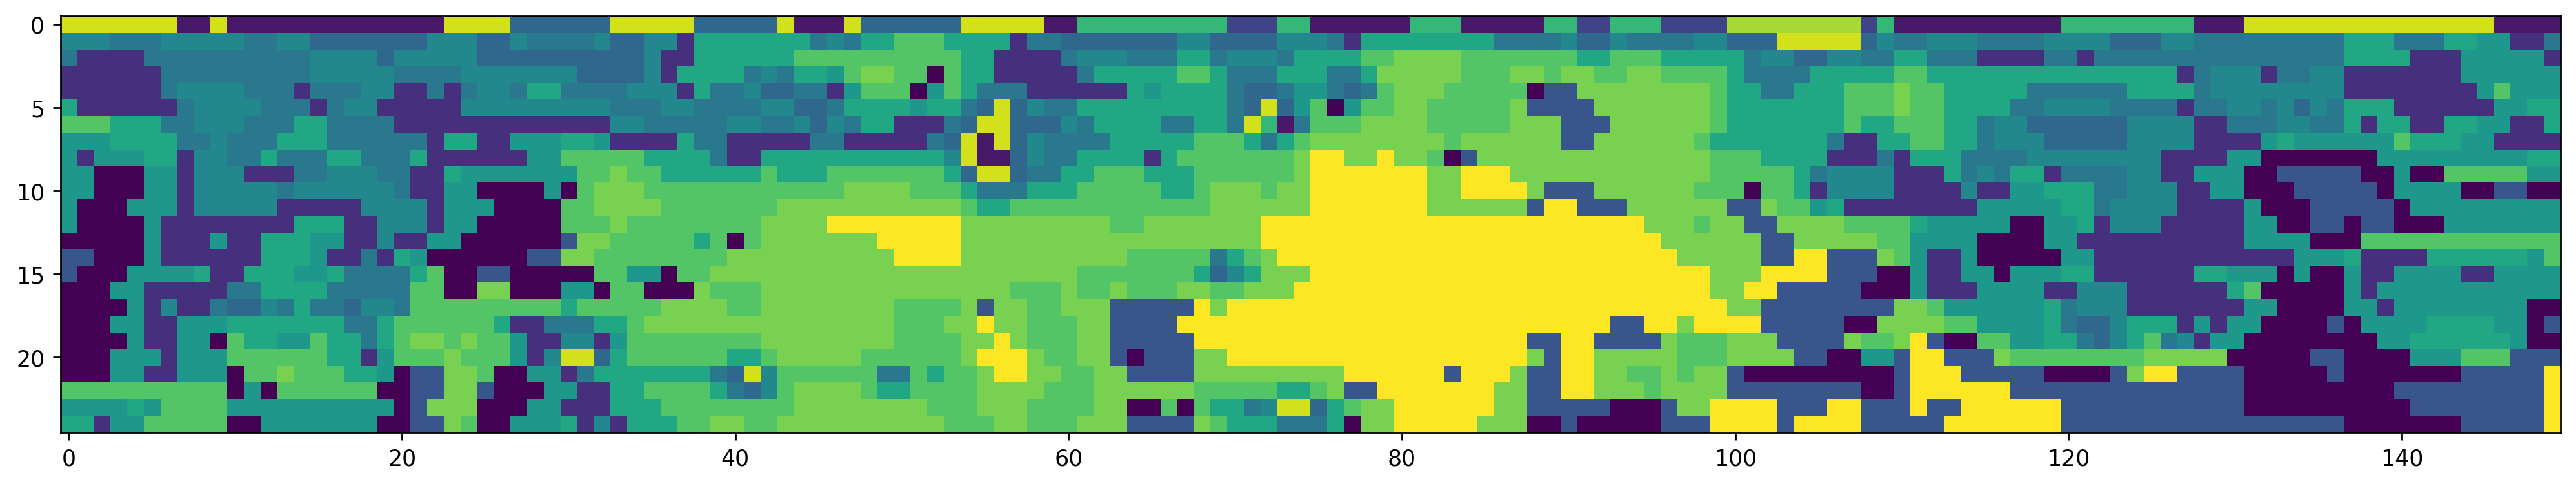

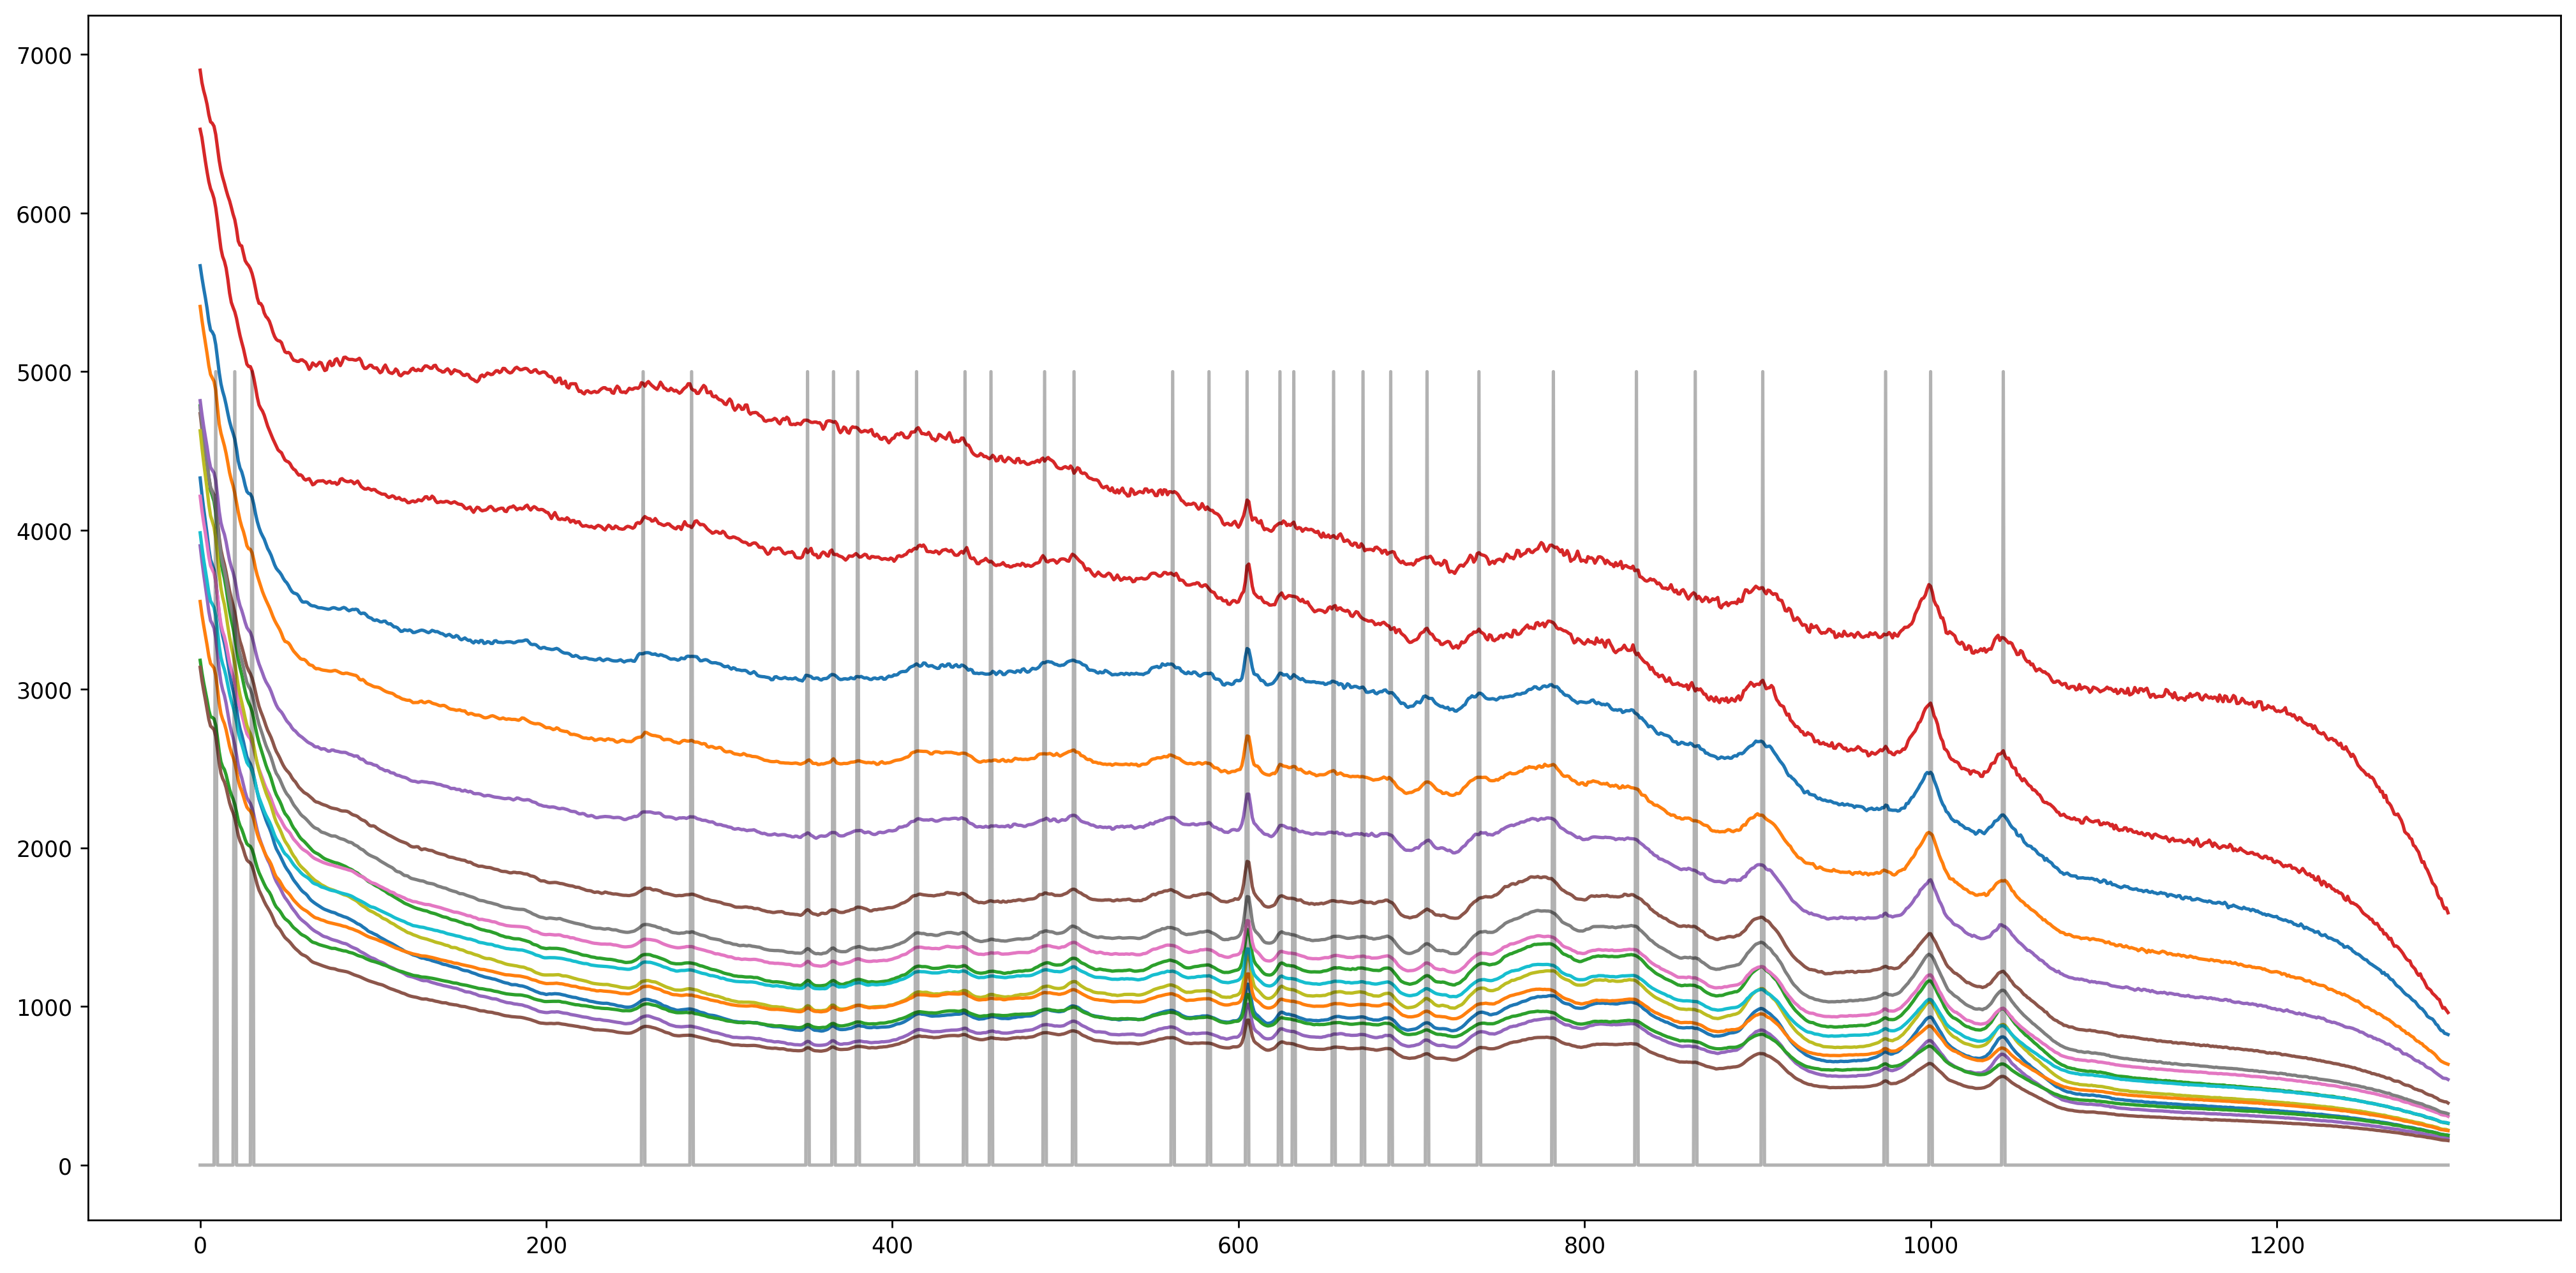

In [46]:
# clustering using the raw signal
kmeans = KMeans(n_clusters=clusters).fit(x)
labels = kmeans.labels_.reshape(img.shape[0],-1)
plt.imshow(labels.T)
plt.show()

for i in range(clusters):
    plt.plot(np.mean(img[np.where(labels==i)], 0))
plt.plot(mask*5000, 'k', alpha=0.3)
plt.show()

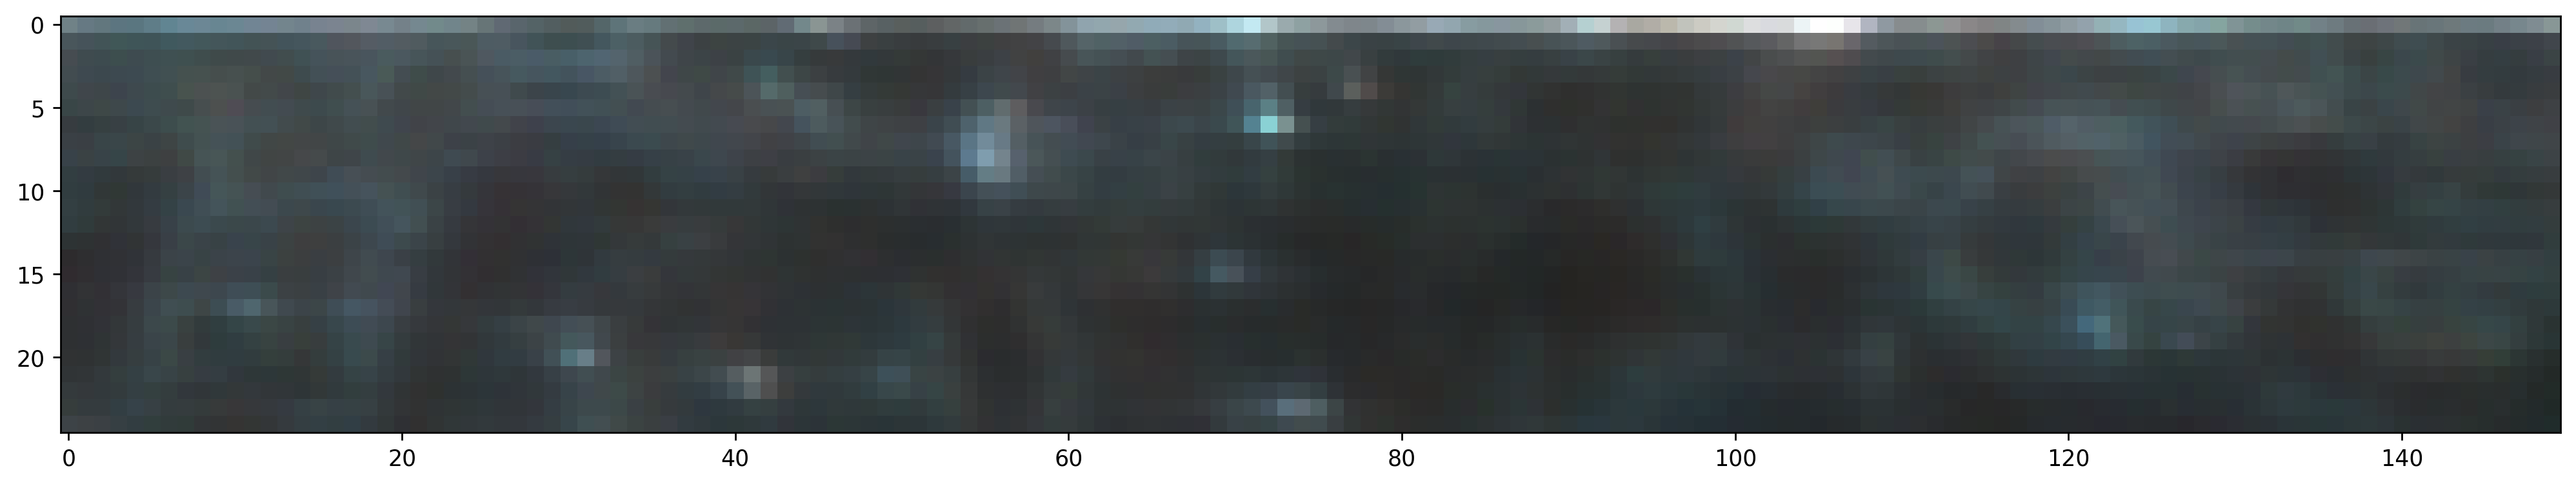

In [47]:
spike = np.where(mask)[0]
photo = img[:,:,(spike[3],spike[13],spike[20])]
photo[:,:,0] /= np.max(photo[:,:,0])
photo[:,:,1] /= np.max(photo[:,:,1])
photo[:,:,2] /= np.max(photo[:,:,2])

plt.imshow(np.rollaxis(photo,1))